<a href="https://colab.research.google.com/github/yiwenwangANU/Machine_Learning/blob/main/04_Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import zipfile

!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-05-24 01:34:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.251.120.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   100MB/s    in 1.6s    

2022-05-24 01:34:52 (100 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"Current path: {dirpath}, number of dirs: {len(dirnames)}, number of files: {len(filenames)}")

Current path: 10_food_classes_10_percent, number of dirs: 2, number of files: 0
Current path: 10_food_classes_10_percent/train, number of dirs: 10, number of files: 0
Current path: 10_food_classes_10_percent/train/sushi, number of dirs: 0, number of files: 75
Current path: 10_food_classes_10_percent/train/pizza, number of dirs: 0, number of files: 75
Current path: 10_food_classes_10_percent/train/grilled_salmon, number of dirs: 0, number of files: 75
Current path: 10_food_classes_10_percent/train/chicken_curry, number of dirs: 0, number of files: 75
Current path: 10_food_classes_10_percent/train/chicken_wings, number of dirs: 0, number of files: 75
Current path: 10_food_classes_10_percent/train/steak, number of dirs: 0, number of files: 75
Current path: 10_food_classes_10_percent/train/fried_rice, number of dirs: 0, number of files: 75
Current path: 10_food_classes_10_percent/train/ice_cream, number of dirs: 0, number of files: 75
Current path: 10_food_classes_10_percent/train/ramen, n

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(directory="10_food_classes_10_percent/train",
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")
train_data_augmented = train_datagen_augmented.flow_from_directory(
    directory="10_food_classes_10_percent/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical")
test_data = test_datagen.flow_from_directory(directory="10_food_classes_10_percent/test",
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [12]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [5]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False,
                                           name="feature_extractor_layer",
                                           input_shape=(224, 224, 3))
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

In [8]:
resnet_model = create_model(resnet_url, train_data.num_classes)

In [11]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
history_resnet = resnet_model.fit(train_data,
                                  epochs=5,
                                  batch_size=32,
                                  steps_per_epoch=len(train_data),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub",
                                                                         "resnet50v2")],
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20220524-014651
Epoch 1/5
24/24 [==============================] - 32s 756ms/step - loss: 2.0327 - accuracy: 0.3147 - val_loss: 1.2967 - val_accuracy: 0.5968
Epoch 2/5
24/24 [==============================] - 16s 673ms/step - loss: 0.9314 - accuracy: 0.7200 - val_loss: 0.8663 - val_accuracy: 0.7208
Epoch 3/5
24/24 [==============================] - 16s 672ms/step - loss: 0.6341 - accuracy: 0.8200 - val_loss: 0.7480 - val_accuracy: 0.7584
Epoch 4/5
24/24 [==============================] - 16s 668ms/step - loss: 0.4771 - accuracy: 0.8613 - val_loss: 0.7103 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 16s 671ms/step - loss: 0.3845 - accuracy: 0.9120 - val_loss: 0.6743 - val_accuracy: 0.7820


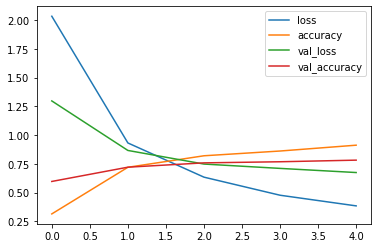

In [17]:
import pandas as pd

pd.DataFrame(history_resnet.history).plot()

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curve(history):
  plt.figure(figsize=(20, 7))
  plt.subplot(1, 2, 1)
  plt.plot(np.arange(len(history.history)+1), history.history["loss"], label="loss")
  plt.plot(np.arange(len(history.history)+1), history.history["val_loss"], label="val_loss")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(len(history.history)+1), history.history["accuracy"], label="accuracy")
  plt.plot(np.arange(len(history.history)+1), history.history["val_accuracy"], label="val_accuracy")
  plt.legend()

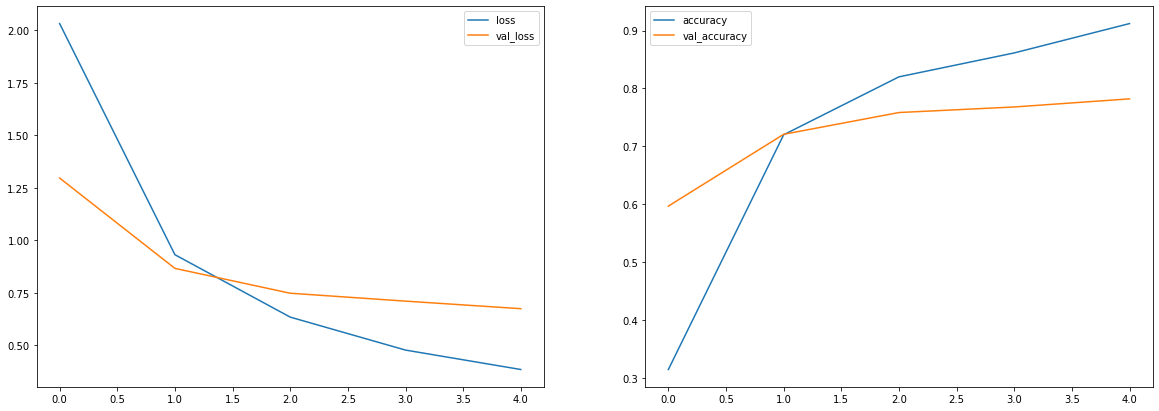

In [29]:
plot_loss_curve(history_resnet)

In [10]:
efficientnet_model = create_model(efficientnet_url, train_data.num_classes)

In [35]:
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [36]:
history_effnet = efficientnet_model.fit(train_data_augmented,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback("tensorflow_hub", "EfficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/EfficientnetB0/20220524-021319
Epoch 1/5
24/24 [==============================] - 31s 975ms/step - loss: 1.9146 - accuracy: 0.3907 - val_loss: 1.3790 - val_accuracy: 0.6800
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.1896 - accuracy: 0.7360 - val_loss: 0.9326 - val_accuracy: 0.7876
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.8613 - accuracy: 0.7893 - val_loss: 0.7427 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 22s 917ms/step - loss: 0.7007 - accuracy: 0.8293 - val_loss: 0.6466 - val_accuracy: 0.8384
Epoch 5/5
24/24 [==============================] - 21s 914ms/step - loss: 0.6258 - accuracy: 0.8400 - val_loss: 0.5865 - val_accuracy: 0.8484


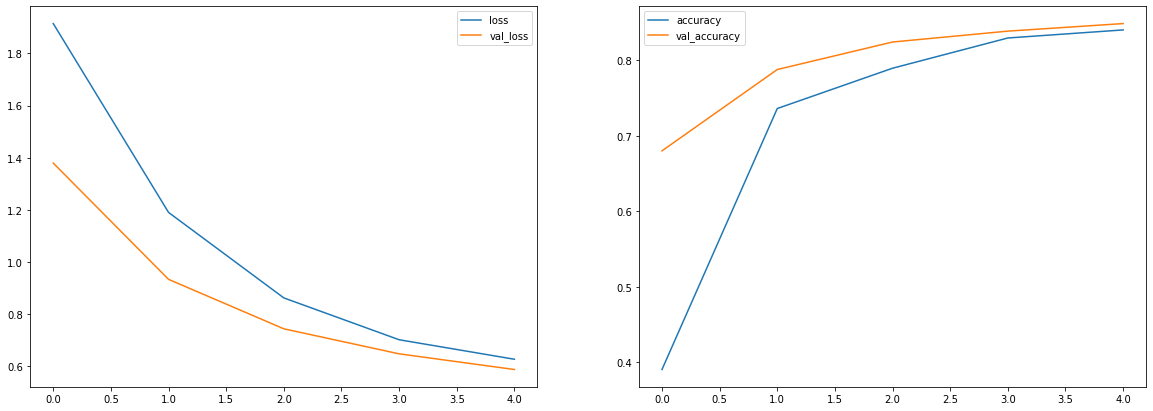

In [37]:
plot_loss_curve(history_effnet)

In [38]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [40]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [41]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 VS ResNet50v2" \
  --description "Comparing two different TF hub feature extraction model architectures using 10% of the training data" \
  --one_shot 


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=OHQIFBfWFZt7IvVt8GrMGJc4NGScoD&prompt=consent&access_type=off

In [42]:
!tensorboard dev list

https://tensorboard.dev/experiment/o3XyeD4ZRYmqGeXM1JpILA/
	Name                 EfficientNetB0 VS ResNet50v2
	Description          Comparing two different TF hub feature extraction model architectures using 10% of the training data
	Id                   o3XyeD4ZRYmqGeXM1JpILA
	Created              2022-05-24 02:45:16 (4 minutes ago)
	Updated              2022-05-24 02:45:18 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5792372
Total: 1 experiment(s)


#Delete experiment from tensorboard

In [ ]:
#!tensorboard dev delete --experiment_id o3XyeD4ZRYmqGeXM1JpILA